# Generating Weekday and Weekend profiles

In [50]:
import polars as pl
import glob
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import logging
from tslearn.clustering import TimeSeriesKMeans 
import re

logging.getLogger('matplotlib.font_manager').disabled = True

from validation import validation

## Weekend profiles

In [51]:
input_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_cleaned")
output_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_weekend_normalized")
output_folder.mkdir(parents=True, exist_ok=True)

pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

def day_avg_preprocess_weekend(df):
    # Parse the timestamp column (assuming 'zeitpunkt' column exists)
    df = df.with_columns(
        pl.col("zeitpunkt").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S%z", strict=False).alias("zeitpunkt_dt")
    )
    
    # Filter only Saturdays (weekday 5) and Sundays (weekday 6)
    df = df.filter(pl.col("zeitpunkt_dt").dt.weekday().is_in([6, 7]))
    
    # Extract time_of_day (hour, minute) as time component
    df = df.with_columns(
        pl.col("zeitpunkt_dt").dt.time().alias("time_of_day")
    )
    
    # Group by time_of_day across all weekend days and average the energy column
    day_avg = (
        df.group_by("time_of_day")
          .agg(pl.col("bruttolastgang_kwh").mean().alias("day_avg_bruttolastgang_kwh"))
          .sort("time_of_day")
    )
    return day_avg

def normalize(df):
    """ Normalize the 'day_avg_bruttolastgang_kwh' column by its max value and overwrite the original column """
    max_val = df.select(pl.max("day_avg_bruttolastgang_kwh"))['day_avg_bruttolastgang_kwh'][0]
    
    if max_val == 0:
        # Avoid division by zero, leave values unchanged
        df = df.with_columns(
            pl.col("day_avg_bruttolastgang_kwh")
        )
    else:
        # Overwrite original column with normalized values
        df = df.with_columns(
            (pl.col("day_avg_bruttolastgang_kwh") / max_val).alias("day_avg_bruttolastgang_kwh")
        )
    
    return df

for file_path in file_paths:
    df = pl.read_csv(file_path)
    day_avg = day_avg_preprocess_weekend(df)
    day_avg = normalize(day_avg)
    
    filename = os.path.basename(file_path)  # Original file name
    output_file = output_folder / filename  # Output path with same filename
    
    day_avg.write_csv(output_file)


    

## Weekday profiles

In [52]:
input_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_cleaned")
output_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_weekday_normalized")
output_folder.mkdir(parents=True, exist_ok=True)

pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

def day_avg_preprocess_weekday(df):
    # Parse the timestamp column (assuming 'zeitpunkt' column exists)
    df = df.with_columns(
        pl.col("zeitpunkt").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S%z", strict=False).alias("zeitpunkt_dt")
    )
    
    # Filter only Saturdays (weekday 5) and Sundays (weekday 6)
    df = df.filter(pl.col("zeitpunkt_dt").dt.weekday().is_in([1,2,3,4,5]))
    
    # Extract time_of_day (hour, minute) as time component
    df = df.with_columns(
        pl.col("zeitpunkt_dt").dt.time().alias("time_of_day")
    )
    
    # Group by time_of_day across all weekend days and average the energy column
    day_avg = (
        df.group_by("time_of_day")
          .agg(pl.col("bruttolastgang_kwh").mean().alias("day_avg_bruttolastgang_kwh"))
          .sort("time_of_day")
    )
    return day_avg

def normalize(df):
    """ Normalize the 'day_avg_bruttolastgang_kwh' column by its max value and overwrite the original column """
    max_val = df.select(pl.max("day_avg_bruttolastgang_kwh"))['day_avg_bruttolastgang_kwh'][0]
    
    if max_val == 0:
        # Avoid division by zero, leave values unchanged
        df = df.with_columns(
            pl.col("day_avg_bruttolastgang_kwh")
        )
    else:
        # Overwrite original column with normalized values
        df = df.with_columns(
            (pl.col("day_avg_bruttolastgang_kwh") / max_val).alias("day_avg_bruttolastgang_kwh")
        )
    
    return df

for file_path in file_paths:
    df = pl.read_csv(file_path)
    day_avg = day_avg_preprocess_weekday(df)
    day_avg = normalize(day_avg)
    
    filename = os.path.basename(file_path)  # Original file name
    output_file = output_folder / filename  # Output path with same filename
    
    day_avg.write_csv(output_file)

## Weekday Clustering-->Difference between weekday and weekend

In [53]:
input_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_weekday_normalized")

pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

n_timestamps = 96

data_list = []
filename_list = []

pattern = re.compile(r"(CH[^_\.]*)")  # Matches 'CH' followed by any chars except _ or .

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    if len(df) == n_timestamps:
        values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
        data_list.append(values_array)
        
        base = os.path.basename(file_path)
        match = pattern.search(base)
        if match:
            filename_list.append(match.group(1))
        else:
            filename_list.append(base)  # fallback to full basename if no CH... found

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")

print(filename_list[:10])  # Preview first 10 extracted CH... names

train_data = data_3d

Shape of the 3D array: (1464, 96, 1)
['CH1018601234500000000000000040851', 'CH1018601234500000000000000047828', 'CH1018601234500000000000000112970', 'CH1018601234500000000000000076787', 'CH1018601234500000000000000067786', 'CH1018601234500000000000000036798', 'CH1018601234500000000000000065363', 'CH1018601234500000000000000065862', 'CH1018601234500000000000000024655', 'CH1018601234500000000000000070197']


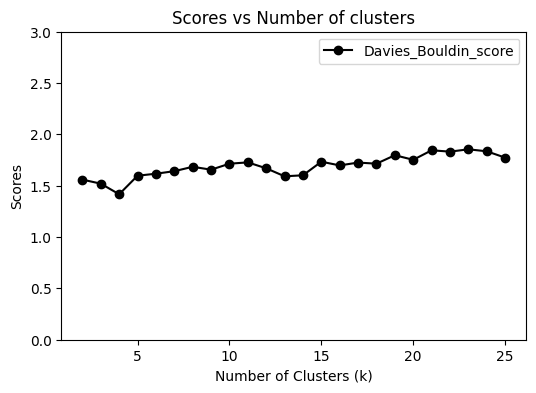

1.4168202268236856


In [54]:
validation(data_3d)

In [55]:
n_clusters = 4  # Number of clusters, you can adjust this
max_iterations =100

kmeans = TimeSeriesKMeans(n_clusters=n_clusters,max_iter=max_iterations, verbose=True, random_state=42, n_jobs=-1)
clusters_train = kmeans.fit_predict(train_data)



3.474 --> 2.466 --> 2.357 --> 2.325 --> 2.309 --> 2.298 --> 2.289 --> 2.284 --> 2.282 --> 2.280 --> 2.278 --> 2.277 --> 2.277 --> 2.277 --> 2.277 --> 2.277 --> 2.277 --> 2.277 --> 


In [56]:
# saves the found clusters in a csv file with the corresponding household IDs

# Convert filename_list items to strings
house_ids = [str(h) for h in filename_list]

# Creates Polars DataFrame with house IDs and clusters
result_df = pl.DataFrame({
    "house_id": house_ids,
    "cluster": clusters_train + 1
}).sort("cluster")
result_df.write_csv('/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/hourly_avg_clustering_weekday.csv')

In [57]:
# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/alle_mittelwerte.csv")  # Adjust path as needed

# Normalize keys in all DataFrames for clean join
# Normalize keys
result_df = result_df.with_columns(
    pl.col("house_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

result_df = result_df.join(
    alle_mittelwerte_df.select([
        "ch_id_clean",
        "bruttolastgang_kwh_sum",
        "average_weekday_daily_consumption",
        "average_weekend_daily_consumption"
    ]),
    on="ch_id_clean",
    how="left"
)
# Now select in the desired order
result_df = result_df.select([
    "house_id",
    "cluster",
    "bruttolastgang_kwh_sum",
    "average_weekday_daily_consumption",
    "average_weekend_daily_consumption"  
])

#print(result_df.head())

cluster_summary = result_df.group_by("cluster").agg([
    pl.count("house_id").alias("num_households"),
    pl.mean("bruttolastgang_kwh_sum").alias("avg_yearly_consumption [kWh]"),
    pl.mean("average_weekday_daily_consumption").alias("average_weekday_daily_consumption [kWh]"),
    pl.mean("average_weekend_daily_consumption").alias("average_weekend_daily_consumption [kWh]")
]).sort("cluster")

# Compute overall averages
overall_yearly_avg = result_df["bruttolastgang_kwh_sum"].mean()
overall_weekday_avg = result_df['average_weekday_daily_consumption'].mean()
overall_weekend_avg = result_df['average_weekend_daily_consumption'].mean()

cluster_summary = cluster_summary.with_columns([
    pl.col("cluster").cast(pl.Utf8)
])
summary_row = pl.DataFrame({
    "cluster": ["Combined"],  # Use 0 or a valid UInt32 value for summary row
    "num_households": [result_df["house_id"].n_unique()],
    "avg_yearly_consumption [kWh]": [overall_yearly_avg],
    "average_weekday_daily_consumption [kWh]": [overall_weekday_avg],
    "average_weekend_daily_consumption [kWh]": [overall_weekend_avg]
})

# Cast to match schema, e.g. cluster and num_households to UInt32
summary_row = summary_row.with_columns([
    pl.col("cluster").cast(cluster_summary["cluster"].dtype),
    pl.col("num_households").cast(cluster_summary["num_households"].dtype)
])

# Concatenate now that dtypes match
final_summary = pl.concat([cluster_summary, summary_row])

print(final_summary)



shape: (5, 5)
┌──────────┬────────────────┬───────────────────────┬───────────────────────┬──────────────────────┐
│ cluster  ┆ num_households ┆ avg_yearly_consumptio ┆ average_weekday_daily ┆ average_weekend_dail │
│ ---      ┆ ---            ┆ n [kWh]               ┆ _consumpt…            ┆ y_consumpt…          │
│ str      ┆ u32            ┆ ---                   ┆ ---                   ┆ ---                  │
│          ┆                ┆ f64                   ┆ f64                   ┆ f64                  │
╞══════════╪════════════════╪═══════════════════════╪═══════════════════════╪══════════════════════╡
│ 1        ┆ 161            ┆ 6236.55541            ┆ 10.581853             ┆ 11.284399            │
│ 2        ┆ 633            ┆ 2906.975738           ┆ 4.839971              ┆ 5.346074             │
│ 3        ┆ 470            ┆ 4544.995383           ┆ 7.786753              ┆ 8.259528             │
│ 4        ┆ 200            ┆ 7525.03524            ┆ 11.544387             ┆

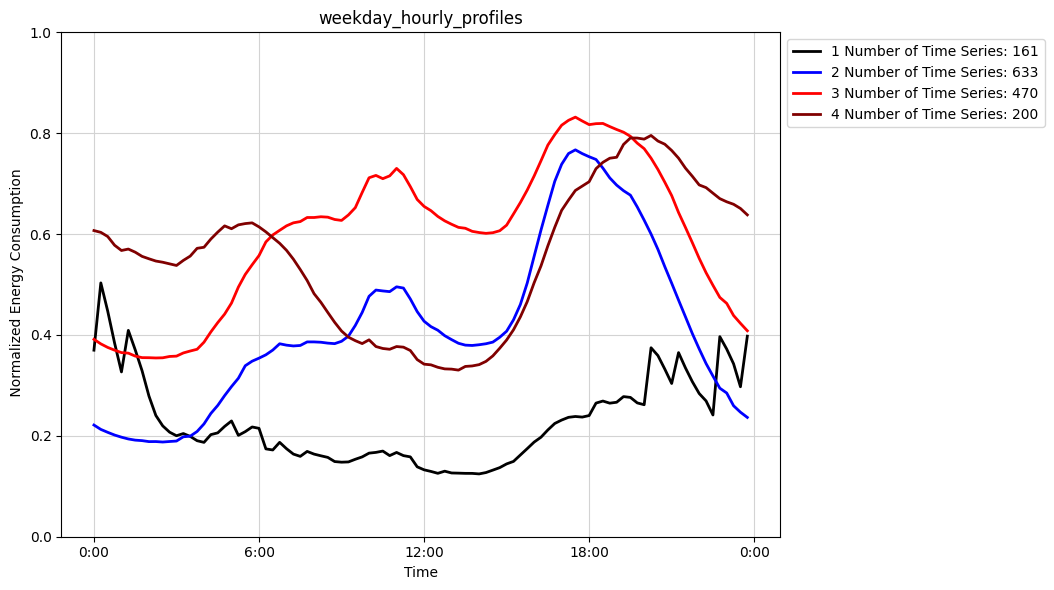

In [58]:
labels = ['0:00','6:00','12:00','18:00','0:00']

colors= ['black','blue','red','maroon','lightgrey','pink','darkgrey','darkblue','skyblue','indianred','purple','magenta','pink','violet']

def plot_clusters_season():
    
    plt.figure(figsize=(8,6))
    for cluster_idx in range(n_clusters):
        # Get all time series in this cluster
        cluster_data = train_data[clusters_train == cluster_idx]
        cluster_indices = np.where(clusters_train == cluster_idx)[0]    
    
        # Calculate the mean time series for the cluster
        mean_time_series = np.mean(cluster_data, axis=0)
    
        # Plot the mean time series
        cluster_no = cluster_idx+1
        plt.plot(range(1,97), mean_time_series.ravel(), 
                label= f'{cluster_no} Number of Time Series: {len(cluster_indices)}',
                linewidth =2, color=colors[cluster_idx] )
    plt.title("weekday_hourly_profiles")
    plt.xlabel("Time")
    plt.ylabel(" Normalized Energy Consumption")
    plt.ylim(0,1)
    #plt.xticks(range(1,108,12),labels=labels)
    plt.xticks(range(1,120,24),labels=labels)
    plt.tight_layout()
    #plt.legend()
    #plt.margins(0)
    plt.grid(True, color = 'lightgray')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

plot_clusters_season()

In [59]:
input_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_weekend_normalized")

pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

n_timestamps = 96

data_list = []
filename_list = []

pattern = re.compile(r"(CH[^_\.]*)")  # Matches 'CH' followed by any chars except _ or .

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    if len(df) == n_timestamps:
        values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
        data_list.append(values_array)
        
        base = os.path.basename(file_path)
        match = pattern.search(base)
        if match:
            filename_list.append(match.group(1))
        else:
            filename_list.append(base)  # fallback to full basename if no CH... found

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")

print(filename_list[:10])  # Preview first 10 extracted CH... names

train_data = data_3d

Shape of the 3D array: (1464, 96, 1)
['CH1018601234500000000000000040851', 'CH1018601234500000000000000047828', 'CH1018601234500000000000000112970', 'CH1018601234500000000000000076787', 'CH1018601234500000000000000067786', 'CH1018601234500000000000000036798', 'CH1018601234500000000000000065363', 'CH1018601234500000000000000065862', 'CH1018601234500000000000000024655', 'CH1018601234500000000000000070197']


In [60]:
n_clusters = 4  # Number of clusters, you can adjust this
max_iterations =100

kmeans = TimeSeriesKMeans(n_clusters=n_clusters,max_iter=max_iterations, verbose=True, random_state=42, n_jobs=-1)
clusters_train = kmeans.fit_predict(train_data)



3.943 --> 2.439 --> 2.317 --> 2.278 --> 2.260 --> 2.252 --> 2.250 --> 2.249 --> 2.249 --> 2.247 --> 2.247 --> 2.247 --> 2.247 --> 2.247 --> 2.247 --> 2.247 --> 2.247 --> 


In [61]:
# saves the found clusters in a csv file with the corresponding household IDs

# Convert filename_list items to strings
house_ids = [str(h) for h in filename_list]

# Creates Polars DataFrame with house IDs and clusters
result_df = pl.DataFrame({
    "house_id": house_ids,
    "cluster": clusters_train + 1
}).sort("cluster")
result_df.write_csv('/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/hourly_avg_clustering_weekend.csv')

In [62]:
# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/alle_mittelwerte.csv")  # Adjust path as needed

# Normalize keys in all DataFrames for clean join
# Normalize keys
result_df = result_df.with_columns(
    pl.col("house_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

result_df = result_df.join(
    alle_mittelwerte_df.select([
        "ch_id_clean",
        "bruttolastgang_kwh_sum",
        "average_weekday_daily_consumption",
        "average_weekend_daily_consumption"
    ]),
    on="ch_id_clean",
    how="left"
)
# Now select in the desired order
result_df = result_df.select([
    "house_id",
    "cluster",
    "bruttolastgang_kwh_sum",
    "average_weekday_daily_consumption",
    "average_weekend_daily_consumption"  
])

#print(result_df.head())

cluster_summary = result_df.group_by("cluster").agg([
    pl.count("house_id").alias("num_households"),
    pl.mean("bruttolastgang_kwh_sum").alias("avg_yearly_consumption [kWh]"),
    pl.mean("average_weekday_daily_consumption").alias("average_weekday_daily_consumption [kWh]"),
    pl.mean("average_weekend_daily_consumption").alias("average_weekend_daily_consumption [kWh]")
]).sort("cluster")

# Compute overall averages
overall_yearly_avg = result_df["bruttolastgang_kwh_sum"].mean()
overall_weekday_avg = result_df['average_weekday_daily_consumption'].mean()
overall_weekend_avg = result_df['average_weekend_daily_consumption'].mean()

cluster_summary = cluster_summary.with_columns([
    pl.col("cluster").cast(pl.Utf8)
])
summary_row = pl.DataFrame({
    "cluster": ["Combined"],  # Use 0 or a valid UInt32 value for summary row
    "num_households": [result_df["house_id"].n_unique()],
    "avg_yearly_consumption [kWh]": [overall_yearly_avg],
    "average_weekday_daily_consumption [kWh]": [overall_weekday_avg],
    "average_weekend_daily_consumption [kWh]": [overall_weekend_avg]
})

# Cast to match schema, e.g. cluster and num_households to UInt32
summary_row = summary_row.with_columns([
    pl.col("cluster").cast(cluster_summary["cluster"].dtype),
    pl.col("num_households").cast(cluster_summary["num_households"].dtype)
])

# Concatenate now that dtypes match
final_summary = pl.concat([cluster_summary, summary_row])

print(final_summary)



shape: (5, 5)
┌──────────┬────────────────┬───────────────────────┬───────────────────────┬──────────────────────┐
│ cluster  ┆ num_households ┆ avg_yearly_consumptio ┆ average_weekday_daily ┆ average_weekend_dail │
│ ---      ┆ ---            ┆ n [kWh]               ┆ _consumpt…            ┆ y_consumpt…          │
│ str      ┆ u32            ┆ ---                   ┆ ---                   ┆ ---                  │
│          ┆                ┆ f64                   ┆ f64                   ┆ f64                  │
╞══════════╪════════════════╪═══════════════════════╪═══════════════════════╪══════════════════════╡
│ 1        ┆ 451            ┆ 2773.111856           ┆ 4.635518              ┆ 5.103945             │
│ 2        ┆ 588            ┆ 3794.561638           ┆ 6.343275              ┆ 6.982091             │
│ 3        ┆ 147            ┆ 6865.172435           ┆ 11.590599             ┆ 12.245702            │
│ 4        ┆ 278            ┆ 7173.740658           ┆ 11.553054             ┆

In [63]:
labels = ['0:00','6:00','12:00','18:00','0:00']

colors= ['black','blue','red','maroon','lightgrey','pink','darkgrey','darkblue','skyblue','indianred','purple','magenta','pink','violet']

def plot_clusters_season():
    
    plt.figure(figsize=(8,6))
    for cluster_idx in range(n_clusters):
        # Get all time series in this cluster
        cluster_data = train_data[clusters_train == cluster_idx]
        cluster_indices = np.where(clusters_train == cluster_idx)[0]    
    
        # Calculate the mean time series for the cluster
        mean_time_series = np.mean(cluster_data, axis=0)
    
        # Plot the mean time series
        cluster_no = cluster_idx+1
        plt.plot(range(1,97), mean_time_series.ravel(), 
                label= f'{cluster_no} Number of Time Series: {len(cluster_indices)}',
                linewidth =2, color=colors[cluster_idx] )
    plt.title("weekend_hourly_profiles")
    plt.xlabel("Time")
    plt.ylabel(" Normalized Energy Consumption")
    plt.ylim(0,1)
    #plt.xticks(range(1,108,12),labels=labels)
    plt.xticks(range(1,120,24),labels=labels)
    plt.tight_layout()
    #plt.legend()
    #plt.margins(0)
    plt.grid(True, color = 'lightgray')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

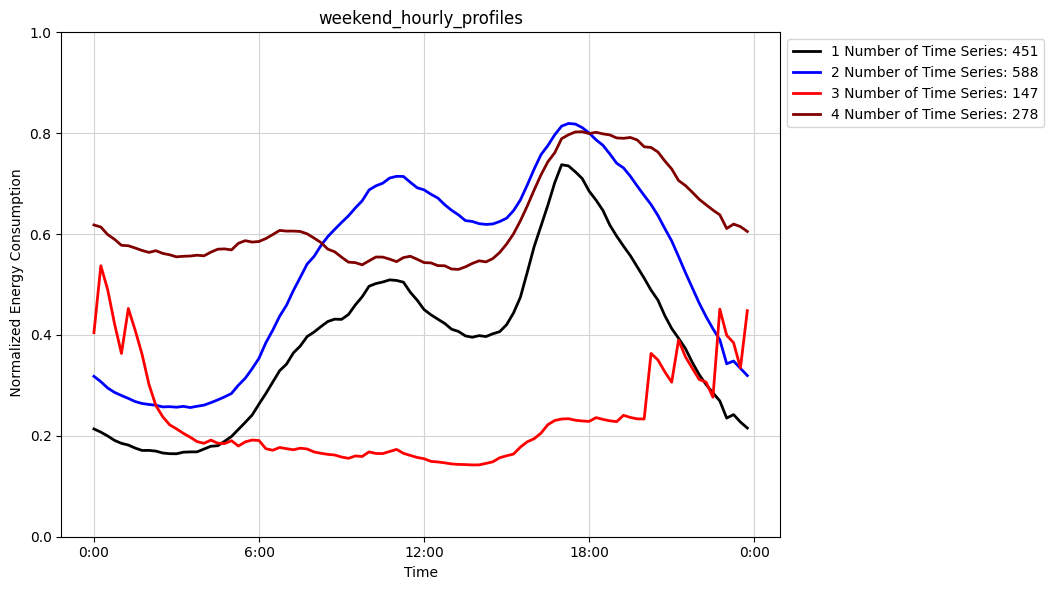

In [64]:
plot_clusters_season()

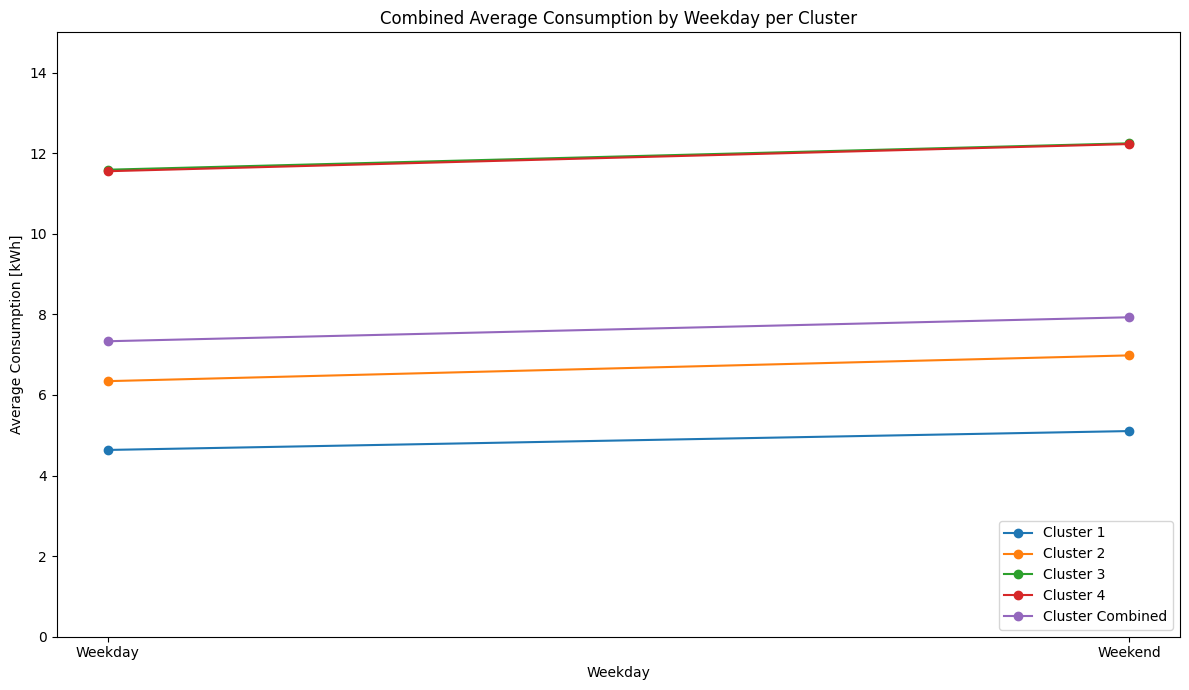

In [65]:
type = ['Weekday', 'Weekend']
clusters = final_summary["cluster"].to_list()

plt.figure(figsize=(12, 7))

for cluster in clusters:
    # Filter the cluster row
    row = final_summary.filter(pl.col("cluster") == cluster).select([
        "average_weekday_daily_consumption [kWh]", "average_weekend_daily_consumption [kWh]"
    ])
    consumption = row[0, :].to_numpy().flatten().tolist()
    plt.plot(type, consumption, marker='o', label=f"Cluster {cluster}")

plt.xlabel('Weekday')
plt.ylabel('Average Consumption [kWh]')
plt.title('Combined Average Consumption by Weekday per Cluster')
plt.legend(loc='lower right')
plt.ylim(0,15)
plt.grid(False)
plt.tight_layout()
plt.savefig("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/Plots/Plots_daily/" \
    "weekday_weekend_evolution.svg")
plt.show()